In [1]:
import numpy as np

from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Setting Up Data

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train_new = X_train.reshape(len(X_train),-1)
X_valid_new = X_valid.reshape(len(X_valid),-1)

In [3]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

In [4]:
class_names = ["T-shirt/top",
               "Trouser",
               "Pullover",
               "Dress",
               "Coat",
               "Sandal",
               "Shirt",
               "Sneaker",
               "Bag",
               "Ankle boot"]

In [5]:
pca = PCA(n_components=28,
          random_state=42)
pca.fit(X_train_new)
X_train_new = pca.transform(X_train_new)
X_valid_new = pca.transform(X_valid_new)

## Clustering

### Hyper-Parameter Tuning

In [6]:
kmeans_per_k = [KMeans(n_clusters=k,
                       init="k-means++",
                       max_iter=100,
                       n_init=10,
                       random_state=42)\
                        .fit(X_train_new)
                    for k in range(50, 1000 + 1, 50)]

inertias = [model.inertia_ for model in kmeans_per_k]

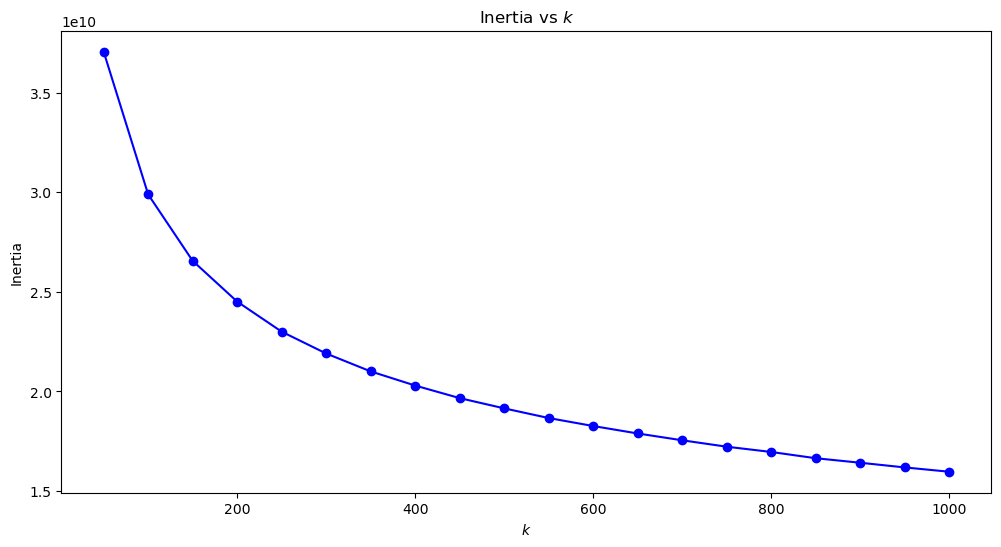

In [7]:
plt.figure(figsize=(12,6))
plt.plot([i for i in range(50, 1000 + 1, 50)],
         inertias,
         "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.title("Inertia vs $k$")
plt.show()

### Final Clustering

In [21]:
k = 450
kmeans = KMeans(n_clusters = k,
                n_init=10,
                init= 'k-means++',
                random_state = 42)
kmeans.fit(X_train_new)
cluster_distance = kmeans.transform(X_train_new)

# MLPs

## Model 1

In [22]:
km_old_labels = kmeans.labels_
closest = np.argmin(cluster_distance, axis = 0)
labels = np.array([y_train[i] for i in closest])

In [23]:
tf.random.set_seed(42)
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dense(300, activation="relu"))
model1.add(tf.keras.layers.Dense(100, activation="relu"))
model1.add(tf.keras.layers.Dense(10, activation="softmax"))

model1.compile(loss="sparse_categorical_crossentropy",
               optimizer="sgd",
               metrics=["accuracy"])

history = model1.fit(X_train,
                     y_train,
                     epochs=15,
                     use_multiprocessing=True,
                     verbose=0,
                     validation_data=(X_valid, y_valid))

### Plotting Results

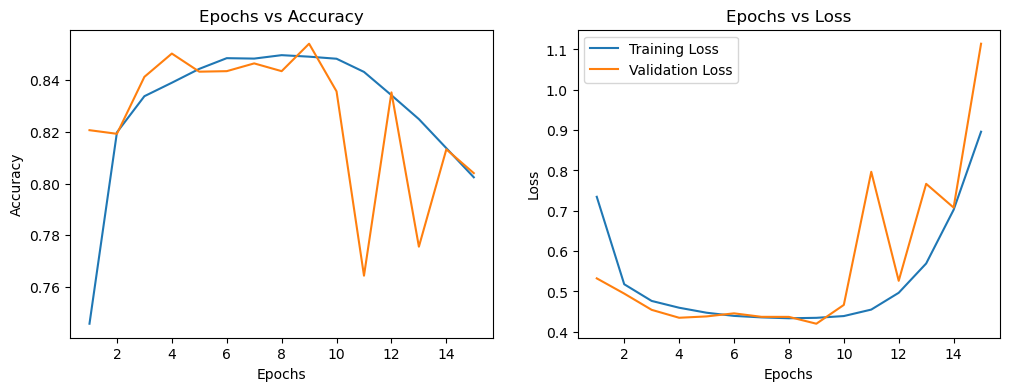

In [24]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = list(range(1, len(train_loss) + 1))

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot data on each subplot
ax1.plot(epochs, train_acc, label="Training Accuracy")
ax1.plot(epochs, val_acc, label="Validation Accuracy")
ax2.plot(epochs, train_loss, label="Training Loss")
ax2.plot(epochs, val_loss, label="Validation Loss")

# Add labels and title
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Epochs vs Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Epochs vs Loss")

# Add legend
plt.legend()

# Show the plot
plt.show()

## Model 2

In [25]:
X_train_ri = np.array([X_train[i] for i in closest])
y_train_ri = np.array([y_train[i] for i in closest])

In [26]:
tf.random.set_seed(42)
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(300, activation="relu"))
model2.add(tf.keras.layers.Dense(100, activation="relu"))
model2.add(tf.keras.layers.Dense(10, activation="softmax"))

model2.compile(loss="sparse_categorical_crossentropy",
               optimizer="sgd",
               metrics=["accuracy"])

history = model2.fit(X_train_ri, 
                     y_train_ri, 
                     epochs=15,
                     use_multiprocessing=True,
                     verbose=0,
                     validation_data=(X_valid, y_valid))

### Plotting Results

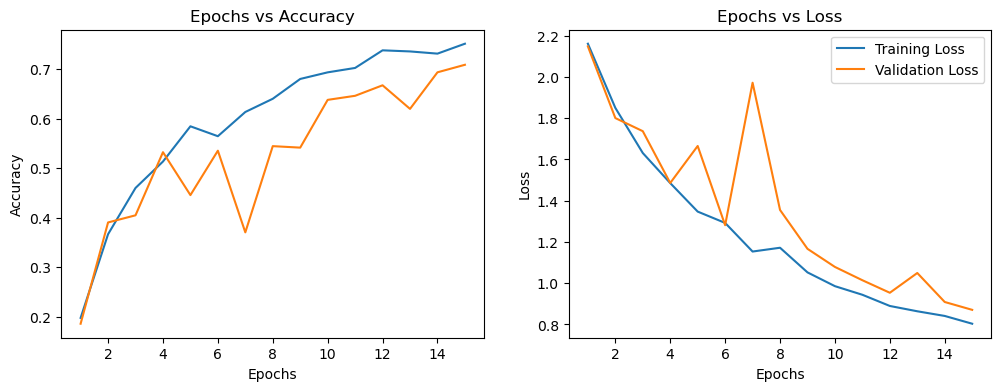

In [27]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = list(range(1, len(train_loss) + 1))

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot data on each subplot
ax1.plot(epochs, train_acc, label="Training Accuracy")
ax1.plot(epochs, val_acc, label="Validation Accuracy")
ax2.plot(epochs, train_loss, label="Training Loss")
ax2.plot(epochs, val_loss, label="Validation Loss")

# Add labels and title
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Epochs vs Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Epochs vs Loss")

# Add legend
plt.legend()

# Show the plot
plt.show()

## Model 3

In [28]:
X_train_fp = X_train
y_train_fp = np.empty(len(X_train_fp), dtype=np.int32)
for i in range(0,len(X_train_fp)):
   y_train_fp[i] = labels[km_old_labels[i]]

In [29]:
tf.random.set_seed(42)
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(300, activation="relu"))
model3.add(tf.keras.layers.Dense(100, activation="relu"))
model3.add(tf.keras.layers.Dense(10, activation="softmax"))

model3.compile(loss="sparse_categorical_crossentropy",
               optimizer="sgd",
               metrics=["accuracy"])

history = model3.fit(X_train_fp,
                     y_train_fp,
                     epochs=15,
                     use_multiprocessing=True,
                     verbose=0,
                     validation_data=(X_valid, y_valid))

### Plotting Results

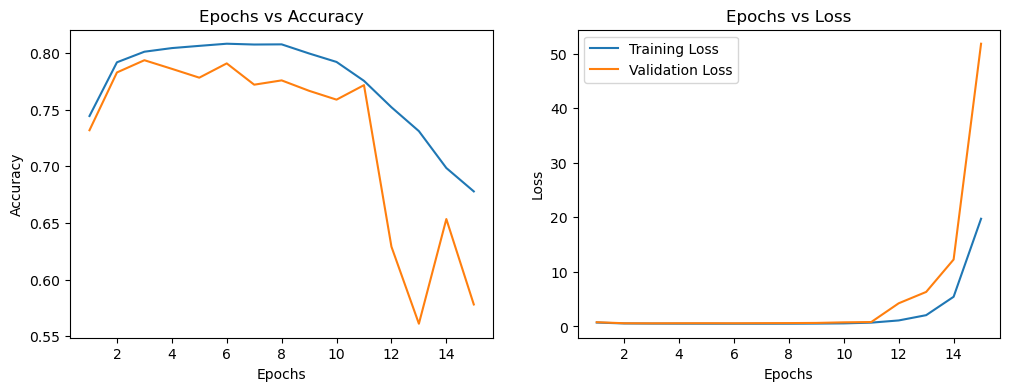

In [30]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = list(range(1, len(train_loss) + 1))

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot data on each subplot
ax1.plot(epochs, train_acc, label="Training Accuracy")
ax1.plot(epochs, val_acc, label="Validation Accuracy")
ax2.plot(epochs, train_loss, label="Training Loss")
ax2.plot(epochs, val_loss, label="Validation Loss")

# Add labels and title
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Epochs vs Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Epochs vs Loss")

# Add legend
plt.legend()

# Show the plot
plt.show()

## Model 4

In [31]:
X_distances = cluster_distance[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_distances[in_cluster]
    cutoff = np.percentile(cluster_dist, 20)
    above_cutoff = (X_distances > cutoff)
    X_distances[in_cluster & above_cutoff] = -1

pp = (X_distances != -1)
X_train_pp = X_train[pp]
y_train_pp = y_train_fp[pp]

In [32]:
tf.random.set_seed(42)
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model4.add(tf.keras.layers.Flatten())
model4.add(tf.keras.layers.Dense(300, activation="relu"))
model4.add(tf.keras.layers.Dense(100, activation="relu"))
model4.add(tf.keras.layers.Dense(10, activation="softmax"))

model4.compile(loss="sparse_categorical_crossentropy",
               optimizer="sgd",
               metrics=["accuracy"])

history = model4.fit(X_train_pp,
                     y_train_pp, 
                     epochs=15,
                     use_multiprocessing=True,
                     verbose=0,
                     validation_data=(X_valid, y_valid))

### Plotting Results

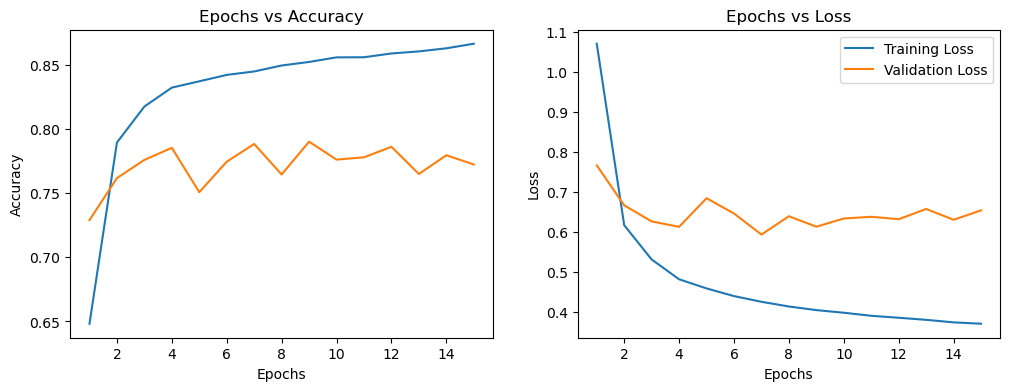

In [33]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = list(range(1, len(train_loss) + 1))

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot data on each subplot
ax1.plot(epochs, train_acc, label="Training Accuracy")
ax1.plot(epochs, val_acc, label="Validation Accuracy")
ax2.plot(epochs, train_loss, label="Training Loss")
ax2.plot(epochs, val_loss, label="Validation Loss")

# Add labels and title
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Epochs vs Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Epochs vs Loss")

# Add legend
plt.legend()

# Show the plot
plt.show()